# import libraries and data 

In [74]:
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import geopy
import mapclassify
from geopy.geocoders import Nominatim
import geocoder
from shapely.geometry import Point, Polygon
import pyrosm
from db import Database

db = Database()



data_folder = '../data/'

# Read in the data
df1 = gpd.read_file(data_folder + 'NYKO_2017_-_nivå_1.geojson')
df3 = gpd.read_file(data_folder + 'NYKO_2017_-_nivå_3.geojson')

## spatial projection
i choose this projectio because is the best for sweden, talk about also others

In [85]:
proj = 'EPSG:32633'

df1 = df1.to_crs(proj) # EPSG:2836
df3 = df3.to_crs(proj)


## spatial operation
now i want only thw city of uppsala and not the county becuse i have data of different levels 
- level 1 just distinguish between the city and the county
- level 3 is more detailed and distinguish between the different districts of the city

In [80]:
df3['centroid'] = df3['geometry'].centroid
df3['is_city'] = df3['centroid'].within(df1.loc[0].geometry)
df = df3[df3.is_city]
df = df.rename(columns={'N3Namn17': 'name', 'N3Kod17': 'district_id'}) 


# geocoding 
take name of the university and map to a point in the map and reverse with geopy

In [97]:
# find university lat and long and project to the right coordinate system


uni_name = "Ångströmlaboratoriet, Uppsala"
location = geocoder.osm(uni_name)
uni_coords = location.latlng
uni = Point(uni_coords[1], uni_coords[0])
uni = gpd.GeoDataFrame({'geometry': uni}, index=[0], crs="EPSG:4326").to_crs(proj)#.geometry[0]



In [100]:
m = df.explore()
m

In [ ]:
import owslib
from owslib.csw import CatalogueServiceWeb ???


# open street map 
prendere dati bus e supermercato magari altro e mescolarlo con i dati di uppsala

In [147]:
# load osm file 

bus_stops = db.get_bus_stops()
supermarkets = db.get_supermarkets()

bus_stops = bus_stops.to_crs(proj)
supermarkets = supermarkets.to_crs(proj)


<AxesSubplot:>

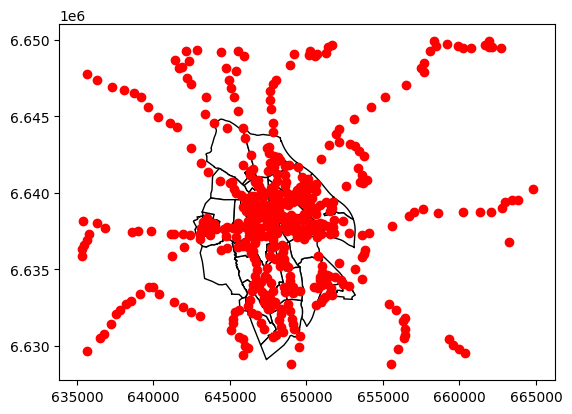

In [137]:
ax = df.plot(color='white', edgecolor='black')
bus_stops.plot(ax=ax, color='red')


In [207]:
# add district to bus_stops
for i, bus_stop in bus_stops.iterrows():
    district =  df[df.contains(bus_stop.geometry)]
    if len(district) > 0:
        district = district.iloc[0].name
    else:
        district = None
    bus_stops.loc[i, 'district'] = district

# add district to supermarkets
for i, supermarket in supermarkets.iterrows():
    district =  df[df.contains(supermarket.geometry)]
    if len(district) > 0:
        district = district.iloc[0].name
    else:
        district = None
    supermarkets.loc[i, 'district'] = district
    


<AxesSubplot:>

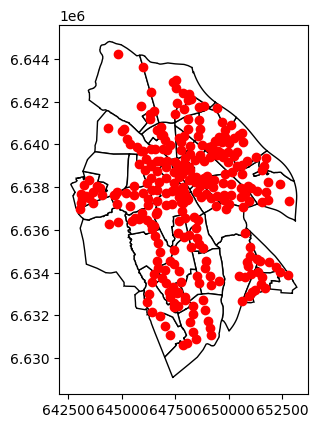

In [205]:
ax = df.plot(color='white', edgecolor='black')
bus_stops.plot(ax=ax, color='red')

In [208]:
stop_frequence = bus_stops.value_counts('district').to_frame()
stop_frequence.rename(columns={0: 'bus_stop_count'}, inplace=True)

supermarket_frequence = supermarkets.value_counts('district').to_frame()
supermarket_frequence.rename(columns={0: 'supermarket_count'}, inplace=True)

In [209]:
df = df.merge(stop_frequence, left_index=True, right_index=True)
df = df.merge(supermarket_frequence, left_index=True, right_index=True)

In [210]:
bus_stops = bus_stops[-bus_stops['district'].isna()]
supermarkets = supermarkets[-supermarkets['district'].isna()]

In [211]:
df

,OBJECTID,district_id,name,geometry,centroid,is_city,bus_stops,bus_stop_count,supermarket_count
0.0,1,111,Centrum,"POLYGON ((648167.348 6637892.872, 648167.348 6...",POINT (647977.183 6638691.509),True,NaN,14,6
4.0,5,115,Främr Luthagen-Fjärding,"POLYGON ((648072.566 6637675.523, 648072.566 6...",POINT (647382.986 6638554.512),True,NaN,4,1
5.0,6,123,Svartbäcken,"POLYGON ((647229.505 6639289.957, 647229.505 6...",POINT (647105.603 6640182.936),True,NaN,6,1
9.0,10,129,Librobäck-Husbyborg,"POLYGON ((646016.813 6639509.052, 646016.813 6...",POINT (644857.032 6640339.068),True,NaN,8,1
14.0,15,136,Boländerna,"POLYGON ((650827.979 6637053.666, 650915.505 6...",POINT (649962.605 6637845.007),True,NaN,16,2
16.0,17,142,Nåntuna-Vilan,"POLYGON ((650020.609 6631274.432, 650020.609 6...",POINT (650343.055 6633967.148),True,NaN,10,1
21.0,22,152,Ultuna,"POLYGON ((649699.387 6632942.539, 649699.387 6...",POINT (649116.104 6634045.104),True,NaN,6,1
25.0,26,157,Gottsunda,"POLYGON ((647616.561 6632080.227, 647616.561 6...",POINT (647421.895 6632900.239),True,NaN,10,2
27.0,28,159,Bäcklösa,"POLYGON ((648131.511 6632639.557, 648131.511 6...",POINT (648242.856 6633371.557),True,NaN,2,1
31.0,32,164,Eriksberg,"POLYGON ((646128.375 6635789.484, 646128.376 6...",POINT (645993.298 6636432.111),True,NaN,9,3


# netowrk analysis 
find closest bus stop to the university and the closest supermarket, isocrone  etc 

# trajectory analysis ???

# raster data 

# spatial regression

Durbin model, local and global spilpver